## <center>Modelo de treinamento para <ins><b>Hours Guru</b></ins><center>

<p>A idéia é treinar um modelo para identificação do possível numero de horas que serão trabalhados para cada projeto.</p>

> <p>Para isso ele vai considerar o numero de horas contratadas para já saber o que é esperado daquele projeto</p>
> <p>Ele vai usar os apontamentos de horas para ter o valor real do que é esperado para o projeto</p>
> <p>Com o agrupamento mensal a idéia é mensurar o que provávelmente vai ser gasto em horas no próximo mês</p>
> <p>Ao Final de cada mês, quando tiver os valores concretos definidos, comparamos com o previsto para definir a acuracia e treinar o modelo novamente.<p>

## Fazendo os imports necessários

**pandas** para manipulação de dados

**numpy** para operações numéricas

**matplotlib** para visualização gráfica dos dados

**seaborn** embelezamento dos gráficos

**Sklearn** para o aprendizado do modelo

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

<h1>Leitura do dataset</h1>

<p>Schema</p>

| **Campo**       | **Tipo de Dado**      |
|-----------------|-----------------------|
| user            | object                |
| project         | object                |
| period          | object                |
| worked_hours    | float64               |
| contracted_hours| float64               |
| remaining_hours | float64               |

In [33]:
dataset_full_path = "./datasets/training_datas2025-01_to_2025-03"
training_dataset_df = pd.read_csv(dataset_full_path)

<h3>Pré-processamento dos dados para treino e alimentar o modelo</h3>

In [34]:
label_encoder = LabelEncoder()
training_dataset_df['user'] = label_encoder.fit_transform(training_dataset_df['user'])
training_dataset_df['project'] = label_encoder.fit_transform(training_dataset_df['project'])
training_dataset_df['period'] = pd.to_datetime(training_dataset_df['period'])
training_dataset_df['month'] = training_dataset_df['period'].dt.month
training_dataset_df['year'] =  training_dataset_df['period'].dt.year

training_dataset_df['period'] = training_dataset_df['period'].dt.to_period('M')
training_dataset_df.head()

,user,project,period,worked_hours,contracted_hours,remaining_hours,month,year
0,11,4,2025-01,3.00,10.0,7.00,1,2025
1,11,2,2025-01,20.80,100.0,79.20,1,2025
2,4,2,2025-01,3.50,100.0,96.50,1,2025
3,6,1,2025-01,7.25,20.0,12.75,1,2025
4,6,2,2025-01,55.94,100.0,44.06,1,2025


<h3>Visualização dos dados de horas trabalhadas X contratadas por Mês</h3>

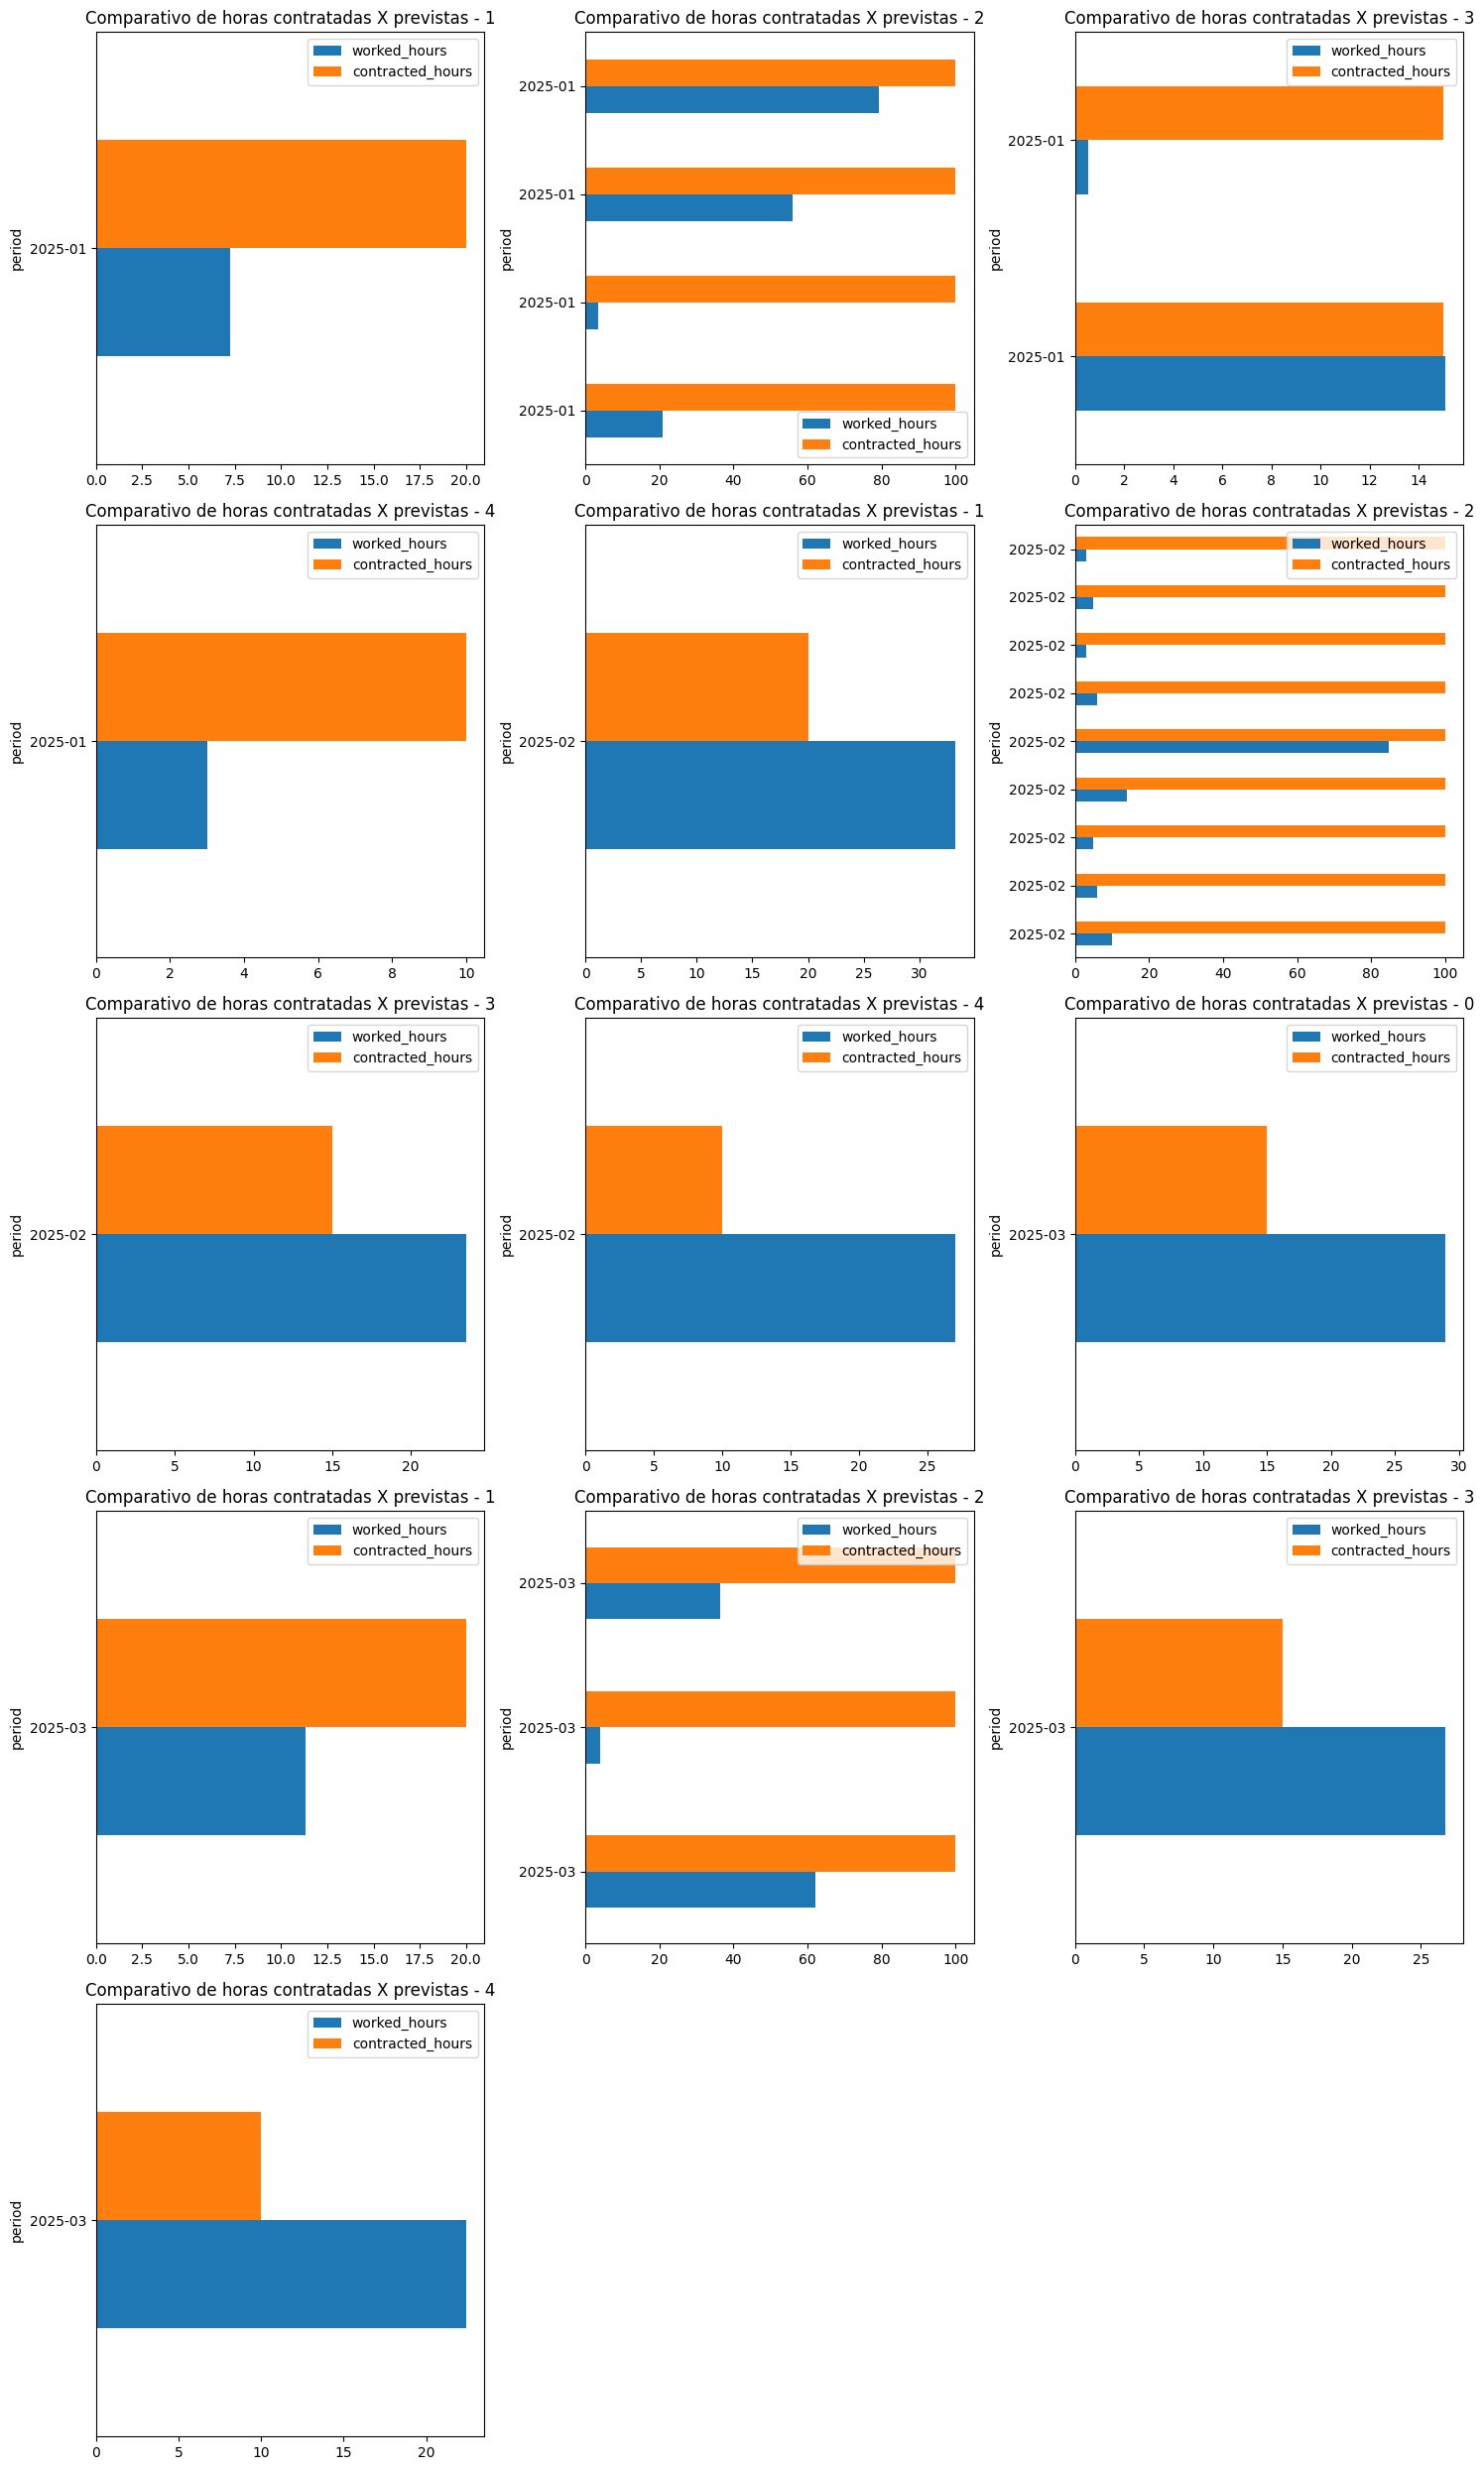

In [35]:
group_by_columns = ['period', 'project']
num_graphs = len(training_dataset_df.groupby(group_by_columns))

cols = 3
rows = (num_graphs // cols) + (num_graphs % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for idx, (name, group) in enumerate(training_dataset_df.groupby(group_by_columns)):
    period, project = name
    ax = axes[idx]
    group.plot(kind='barh', 
               x='period', 
               y=['worked_hours', 'contracted_hours'], 
               ax=ax, 
               title=f"Projeto: {project}",
               legend=True)
    
    ax.set_title(f"Comparativo de horas contratadas X previstas - {project}")

for idx in range(num_graphs, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()

plt.show()


<h3>Visualização dos dados de horas trabalhadas por Mês X usuário</h3>

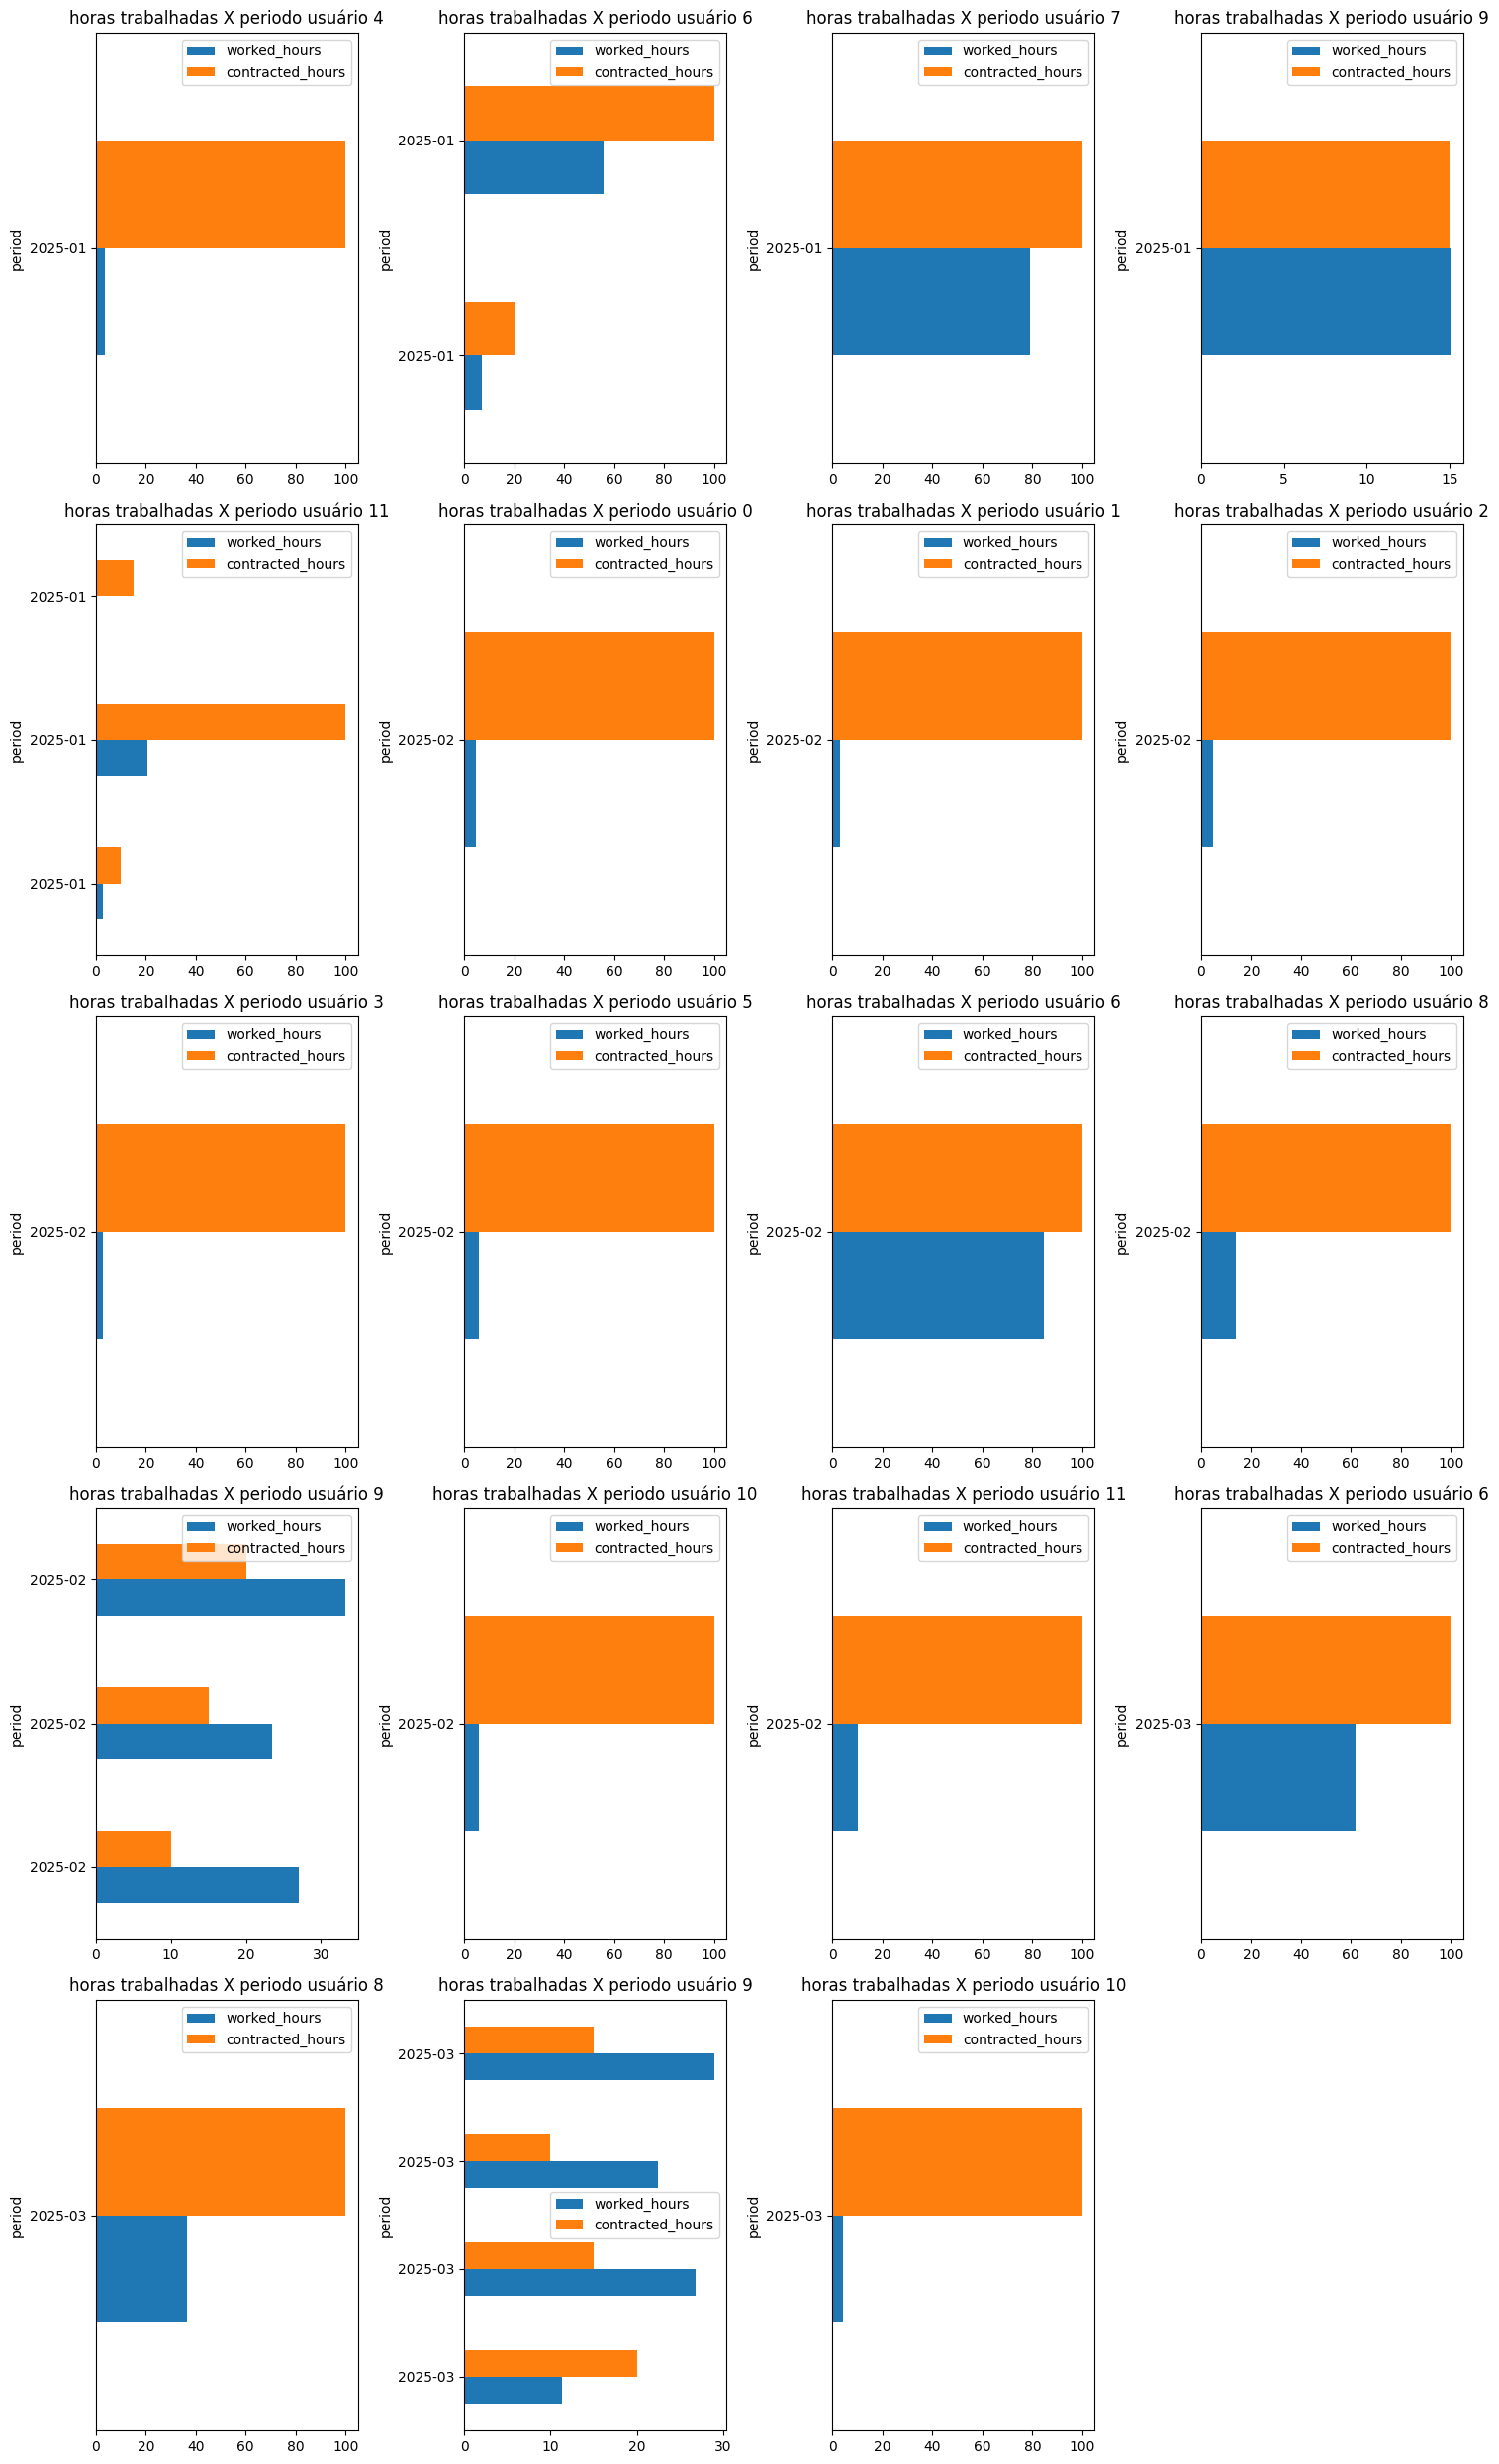

In [36]:
group_by_columns = ['period', 'user']

num_graphs = len(training_dataset_df.groupby(group_by_columns))

cols = 4
rows = (num_graphs // cols) + (num_graphs % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for idx, (name, group) in enumerate(training_dataset_df.groupby(group_by_columns)):
    period, user = name
    ax = axes[idx]
    group.plot(kind='barh', 
               x='period', 
               y=['worked_hours','contracted_hours'], 
               ax=ax, 
               title=f"Usuario: {user}",
               legend=True)
    
    ax.set_title(f"horas trabalhadas X periodo usuário {user}")

for idx in range(num_graphs, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()

plt.show()


### Curando os dados para o treinamento e teste

In [37]:
#Dropar colunas sem agregação
training_dataset_df = training_dataset_df.drop('period', axis=1)

In [38]:
x_columns = ['user', 'month', 'year', 'contracted_hours', 'remaining_hours']

x = training_dataset_df[x_columns]
y = training_dataset_df['worked_hours']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [39]:
x_train
y_train

x_test
y_test

8     10.00
13     4.83
9      6.00
21    62.00
0      3.00
11    23.50
Name: worked_hours, dtype: float64

### Seguindo com o seguindo modelo de regressão linear

**sklear** RandomForestRegressor()

In [40]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_train, y_train)

RandomForestRegressor()

# <center>Testando os modelos.<center>
### <center> apurando as acuracias.<center>

In [41]:
"""
    Testando o modelo de regressão linear com 20% do conjunto de dados.
"""
y_pred_rf_regressor = rf_regressor.predict(x_test)

mse_rf_regressor = mean_squared_error(y_test, y_pred_rf_regressor)
rmse_rf_regressor = mse_rf_regressor ** 0.5
r2_rf_regressor = r2_score(y_test, y_pred_rf_regressor)

print("\nAvaliação do modelo RandomForestRegressor:")
print(f"RMSE: {rmse_rf_regressor:.2f}")
print(f"R²: {r2_rf_regressor:.2f}")


Avaliação do modelo RandomForestRegressor:
RMSE: 3.20
R²: 0.98
